In [1]:
import pandas as pd

DB_URL = 'onad.cbjjamtlar2t.ap-northeast-2.rds.amazonaws.com'
DB_USER = 'onad'
DB_PASSWORD = 'rkdghktn12'
DB_DATABASE = 'onad'
DB_CHARSET = 'utf8mb4'
DB_LOGFLAG  = 'False'
DB_PORT = 3306

db_url = "mysql+pymysql://%s:%s@%s:%s/%s?charset=%s" % (
    DB_USER, DB_PASSWORD,
    DB_URL, DB_PORT,
    DB_DATABASE, DB_CHARSET
)

def data_from_sql_twitchchat(streamer, target_date):
    query = """
        select * from twitch_chat where streamer_name = "%s" and broad_date ="%s"
    """% (streamer, target_date)

    return pd.read_sql_query(query, db_url)

### 1 채팅데이터 로드

In [183]:
streamer = "beyou0728"
target_date = "2019-01-05"
df = data_from_sql_twitchchat(streamer, target_date)

In [184]:
chat_df = df.copy()
chat_df.head(2)

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
0,14348864,beyou0728,2019-01-05,<정의와사랑 (oksk1042)>,00:00:05,어썌신탈런
1,14348865,beyou0728,2019-01-05,<%한태주요 (nanthaeo12)>,00:00:16,역전각 씨게 나오구요


In [185]:
chat_df.shape

(18182, 6)

### 2 시간 인덱스로 변환

In [186]:
# "얍하" 를 기준으로 시작시간 설정
# start_time = chat_df[chat_df.chat_contents == "혁하"]["chat_time"].values[5]
# start_time = target_date + " " + start_time
# start_time = pd.to_datetime(start_time)

In [187]:
chat_df[chat_df.chat_contents == "끠하"].head()

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
97,14348961,beyou0728,2019-01-05,<새봄이꾸냥 (sbferdin)>,00:04:57,끠하
1149,14350013,beyou0728,2019-01-05,<달려라오수생 (dcsenex)>,00:54:33,끠하
1263,14350127,beyou0728,2019-01-05,<%귀지팩트 (jungunim1)>,00:57:45,끠하
1678,14350542,beyou0728,2019-01-05,<ydseo7571>,01:14:29,끠하
2396,14351260,beyou0728,2019-01-05,<+서순맨 (dylee9907)>,01:34:58,끠하


In [188]:
chat_df['stream_time'] = chat_df['chat_time'].apply(lambda x : target_date + " " + x)
# chat_df['stream_time'] = chat_df['stream_time'].apply(lambda x : pd.to_datetime(x) - start_time)
chat_df.index = pd.to_datetime(chat_df['stream_time'])
# chat_df.set_index("stream_time", inplace=True)

In [189]:
# chat_df = chat_df[chat_df.index > "00:00:00"]

In [190]:
chat_df.head()

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents,stream_time
stream_time,,,,,,,
2019-01-05 00:00:05,14348864,beyou0728,2019-01-05,<정의와사랑 (oksk1042)>,00:00:05,어썌신탈런,2019-01-05 00:00:05
2019-01-05 00:00:16,14348865,beyou0728,2019-01-05,<%한태주요 (nanthaeo12)>,00:00:16,역전각 씨게 나오구요,2019-01-05 00:00:16
2019-01-05 00:00:17,14348866,beyou0728,2019-01-05,<ding1002>,00:00:17,집가는거 아님?,2019-01-05 00:00:17
2019-01-05 00:00:34,14348867,beyou0728,2019-01-05,<정의와사랑 (oksk1042)>,00:00:34,이미 블루있지않음?,2019-01-05 00:00:34
2019-01-05 00:00:35,14348868,beyou0728,2019-01-05,<%한태주요 (nanthaeo12)>,00:00:35,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,2019-01-05 00:00:35


### 3 분석데이터셋으로 전처리

#### 3-1 분석 데이터셋 만들기

In [191]:
anal_df = chat_df.pivot_table(index=chat_df.index, values='chatterer', aggfunc=len).loc[:, ['chatterer']]

#### 3-2 변수 추가

In [192]:
word_list = ['ㅋ', '유하', '꿀잼', '?', 'ㄵ', '노잼', 'ㄴㅈ', '혁준',]

for word in word_list:
    target_word = "cnt_" + word
    chat_df[target_word] =  chat_df.chat_contents.apply(lambda x : x.count(word))
    anal_df[target_word] = chat_df.pivot_table(index=chat_df.index, values=target_word, aggfunc=sum).loc[:, target_word]

anal_df['chatterer'].unique().mean(), anal_df['chatterer'].mean()

(6.090909090909091, 1.540716888399288)

In [193]:
import numpy as np
anal_df[anal_df['chatterer'] > np.percentile(anal_df.chatterer.unique(), 60)]

,chatterer,cnt_ㅋ,cnt_유하,cnt_꿀잼,cnt_?,cnt_ㄵ,cnt_노잼,cnt_ㄴㅈ,cnt_혁준
stream_time,,,,,,,,,
2019-01-05 19:19:13,12,14,0,0,0,0,0,0,0
2019-01-05 19:22:55,8,0,0,0,8,0,0,0,0
2019-01-05 19:56:17,8,4,0,0,0,0,0,0,0
2019-01-05 20:46:45,9,76,0,0,0,0,0,0,0
2019-01-05 22:30:32,8,103,0,0,1,0,0,0,0
2019-01-05 22:30:38,8,109,0,0,0,0,0,0,0
2019-01-05 22:30:39,8,78,0,0,1,0,0,0,0
2019-01-05 22:38:29,12,124,0,0,0,0,0,0,0
2019-01-05 22:40:33,10,224,0,0,12,0,0,0,0


In [194]:
anal_df['summation'] = anal_df['chatterer'] + anal_df['cnt_ㅋ']
anal_df['summation+?'] = anal_df['chatterer'] + anal_df['cnt_ㅋ'] + anal_df['cnt_?']

In [195]:
anal_df.shape

(11801, 11)

In [196]:
anal_df.head(2)

,chatterer,cnt_ㅋ,cnt_유하,cnt_꿀잼,cnt_?,cnt_ㄵ,cnt_노잼,cnt_ㄴㅈ,cnt_혁준,summation,summation+?
stream_time,,,,,,,,,,,
2019-01-05 00:00:05,1,0,0,0,0,0,0,0,0,1,1
2019-01-05 00:00:16,1,0,0,0,0,0,0,0,0,1,1


In [197]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
a = pd.DataFrame(sc.fit_transform(anal_df), index=anal_df.index, columns=anal_df.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [198]:
a['summation'] = a['chatterer'] + a['cnt_ㅋ']
a['summation+?'] = a['chatterer'] + a['cnt_ㅋ'] + a['cnt_?']
spot = a[a['summation'] > np.percentile(a['summation'].unique(), 70)]
spot.shape

(124, 11)

In [199]:
a['label'] = a['summation'].apply(lambda x : 1 if x in spot.summation.values else 0)

In [200]:
yes_data = a[a['label'] == 1]
no_data = a[a['label'] == 0]

In [201]:
yes_data.shape, no_data.shape

((124, 12), (11677, 12))

In [202]:
a.head()

,chatterer,cnt_ㅋ,cnt_유하,cnt_꿀잼,cnt_?,cnt_ㄵ,cnt_노잼,cnt_ㄴㅈ,cnt_혁준,summation,summation+?,label
stream_time,,,,,,,,,,,,
2019-01-05 00:00:05,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0
2019-01-05 00:00:16,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0
2019-01-05 00:00:17,0.0,0.000000,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.000000,0.038462,0
2019-01-05 00:00:34,0.0,0.000000,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.000000,0.038462,0
2019-01-05 00:00:35,0.0,0.053571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.053571,0.053571,0


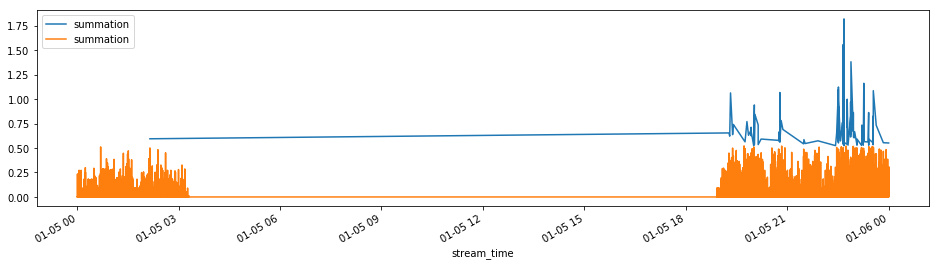

In [204]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
yes_data['summation'].plot(x=a.index, kind='line')
no_data['summation'].plot(x=a.index, kind='line')
plt.legend()
plt.show()

In [205]:
point = anal_df[anal_df['summation+?'] > np.percentile(anal_df.summation.unique(), 70)]

In [206]:
point['time'] = point.index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [207]:
point.head(2)

,chatterer,cnt_ㅋ,cnt_유하,cnt_꿀잼,cnt_?,cnt_ㄵ,cnt_노잼,cnt_ㄴㅈ,cnt_혁준,summation,summation+?,time
stream_time,,,,,,,,,,,,
2019-01-05 02:09:10,4,72,0,0,0,0,0,0,0,76,76,2019-01-05 02:09:10
2019-01-05 19:17:47,4,78,0,0,0,0,0,0,0,82,82,2019-01-05 19:17:47


In [208]:

point_sections = []
for index in point.index:
    point_section_start = index - pd.Timedelta("20s")
    point_section_end = index + pd.Timedelta("20s")
    point_section = pd.date_range(point_section_start, point_section_end, freq='s')
    point_sections.extend(point_section)
section_index = pd.DataFrame(index = point_sections)

In [209]:
a['stream_time'] = a.index
a['label'] = a['stream_time'].apply(lambda x : 1 if x in point_sections else 0)

In [210]:
yes_df = a[a['label'] == 1]
no_df = a[a['label'] == 0]

In [211]:
yes_df.shape, no_df.shape

((661, 13), (11140, 13))

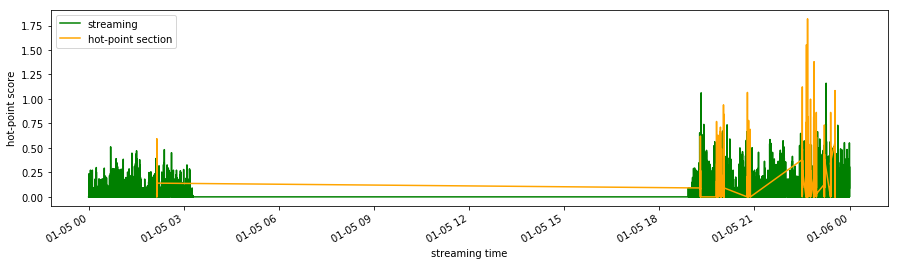

In [212]:
plt.figure(figsize=(15,4))
no_df['summation'].plot(c='g')
yes_df['summation'].plot(c='orange')
plt.legend(['streaming', 'hot-point section'])
plt.xlabel("streaming time")
plt.ylabel("hot-point score")
plt.show()